In [1]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap

%matplotlib inline

In [2]:
try:
    conn = psycopg2.connect(user = "ffunes",
                            password = "location8",
                            host = "127.0.0.1",
                            port = "5432",
                            database = "elecciones_twitter")
except:
    print("No se pudo conectar a la base de datos")

In [3]:
total_followers = pd.read_sql_query('SELECT COUNT(*) FROM followers',con=conn)
total_followers

,count
0,58807767


In [5]:
pd.read_sql_query(
    'SELECT COUNT(*)\
    FROM followers\
    WHERE follower_id IN\
        (SELECT id FROM users)'
    ,con=conn
)

,count
0,58807767


In [6]:
pd.read_sql_query(
    'SELECT COUNT(*)\
    FROM followers\
    WHERE followee_id IN\
        (SELECT id FROM users)'
    ,con=conn
)

,count
0,58807767


In [7]:
follows = pd.read_sql_query(
    'SELECT *\
    FROM followers'
    ,con=conn
)

In [9]:
follows["follower_id"].nunique()

457559

In [10]:
follows["followee_id"].nunique()

994598

In [4]:
usecols = [
    "id",
    "place_name",
    "place_country",
    "latitude",
    "longitude"
]

In [5]:
users = pd.read_pickle("../../../../dosT/ffunes/total_users_parsed.pkl")

In [6]:
users = users.loc[:, usecols]

In [7]:
users.head()

,id,place_name,place_country,latitude,longitude
0,773970163502870528,guadalajara de buga,colombia,3.900890,-76.297829
1,77573705,quito,ecuador,-0.229850,-78.524948
2,782687718576840704,tolosa,españa,43.134838,-2.078010
3,781920345536225280,san pedro,argentina,-33.679180,-59.666328
4,78502559,guayaquil,ecuador,-2.196160,-79.886208


In [8]:
users.shape

(176029, 5)

In [31]:
users_with_followers = pd.merge(
    left=users,
    right=follows,
    how='inner',
    left_on=["id"],
    right_on=["follower_id"],
    validate="1:m" 
)

In [32]:
followers_count = users_with_followers.loc[:,['id', 'followee_id']].\
    drop_duplicates().groupby('followee_id').count()

In [34]:
followers_count.shape

(695417, 1)

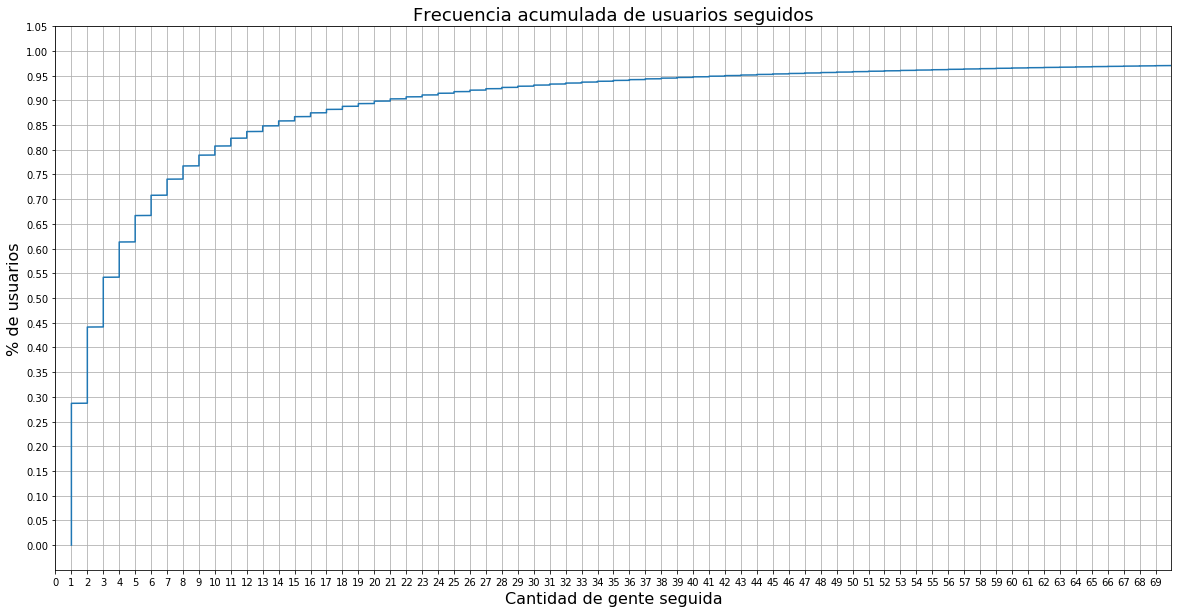

In [35]:
ecdf = ECDF(followers_count["id"])

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Cantidad de gente seguida", fontsize=16)
plt.ylabel("% de usuarios", fontsize=16)
plt.title("Frecuencia acumulada de usuarios seguidos", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.05))
plt.xticks(np.arange(0,70,1))
plt.xlim(0, 70)
#plt.hlines(accuracy_score(y_test[:, 0], y_predicted_city), -200, 1000, colors='r', linestyles='dashed')
#plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [36]:
users_with_followers = users_with_followers.groupby(
        ["id", "place_name", "place_country", "latitude", "longitude"]
    )['followee_id'].apply(list).reset_index(name='followee_id')

In [37]:
users_with_followers.head(2)

,id,place_name,place_country,latitude,longitude,followee_id
0,1059,guernica,argentina,-34.916199,-58.381111,"[55033131, 35778170, 52746198, 130574455, 4747..."
1,2677,lenox,estados unidos,42.356480,-73.284828,"[239026022, 20449296]"


In [38]:
users_with_followers.shape

(69614, 6)

In [39]:
users_with_followers.to_pickle("../../../../dosT/ffunes/users_with_followers.pkl")

Cuantos conservaria si considerar usuarios que me siguen?

In [48]:
users_with_followee = pd.merge(
    left=users,
    right=follows,
    how='inner',
    left_on=["id"],
    right_on=["followee_id"],
    validate="1:m" 
)

In [49]:
followee_count = users_with_followee.loc[:,['id', 'follower_id']].\
    drop_duplicates().groupby('follower_id').count()

In [50]:
followee_count.shape

(452193, 1)

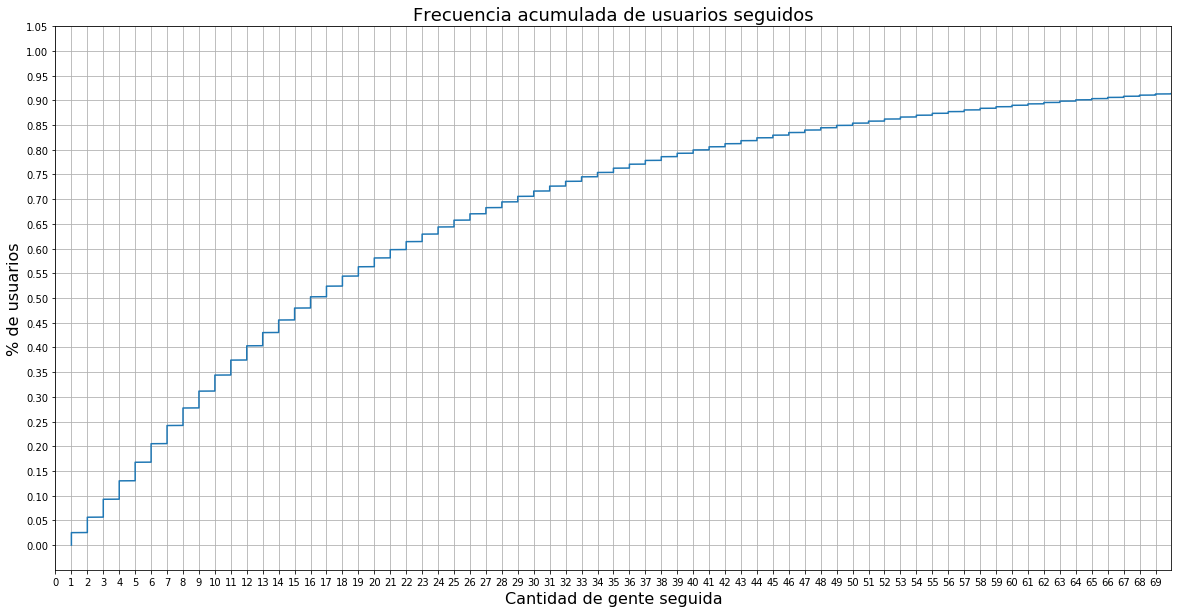

In [52]:
ecdf = ECDF(followee_count["id"])

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Cantidad de gente seguida", fontsize=16)
plt.ylabel("% de usuarios", fontsize=16)
plt.title("Frecuencia acumulada de usuarios seguidos", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.05))
plt.xticks(np.arange(0,70,1))
plt.xlim(0, 70)
#plt.hlines(accuracy_score(y_test[:, 0], y_predicted_city), -200, 1000, colors='r', linestyles='dashed')
#plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [54]:
users_with_followee = users_with_followee.groupby(
        ["id", "place_name", "place_country", "latitude", "longitude"]
    )['follower_id'].apply(list).reset_index(name='follower_id')

In [55]:
users_with_followee.head(2)

,id,place_name,place_country,latitude,longitude,follower_id
0,1059,guernica,argentina,-34.916199,-58.381111,[153373867]
1,2677,lenox,estados unidos,42.356480,-73.284828,"[49958733, 818591]"


In [56]:
users_with_followee.shape

(109969, 6)

In [57]:
users_with_followee.to_pickle("../../../../dosT/ffunes/users_with_followee.pkl")

----------------------------------------------

# Función para calcular distancias entre datos predecidos y reales

In [2]:
geonames = pd.read_pickle("../../../../dosT/ffunes/geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    del df_prediction['predicted_place']
    del df_prediction['real_place']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['predicted_cities', 'predicted_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['real_cities', 'real_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

# Predicciones

In [11]:
users_with_follower = pd.read_pickle("../../../../dosT/ffunes/users_with_followers.pkl")

In [12]:
users_with_follower["followee_id"] = users_with_follower["followee_id"].apply(lambda l: list(map(str, l)))
users_with_follower["id"] = users_with_follower["id"].apply(lambda l: str(l))

In [13]:
users_with_follower["unified_place"] = users_with_follower["place_name"] + ',' + users_with_follower["place_country"]

In [14]:
min_determined_place = users_with_follower.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

In [15]:
min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 475, :]

In [16]:
min_determined_place.shape

(23, 2)

In [17]:
users_train_selected = pd.merge(
    left=users_with_follower,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)
users_train_selected.shape

(29274, 7)

Armado de matriz de adyascencia

In [18]:
users_ids = users_train_selected["id"].apply(lambda l: str(l)).values

In [19]:
a = set()
for x in users_train_selected["followee_id"].values:
    for val in x:
        a.add(str(val))
        
all_users_mentioned = list(a)

In [20]:
total_users = np.concatenate([users_ids, all_users_mentioned])

In [21]:
a = OrderedDict.fromkeys(total_users)

In [22]:
total_users = list(a)

In [23]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    vocabulary=total_users
)

vector_of_followees = vectorizer.fit_transform(users_train_selected["followee_id"].apply(lambda x: ' '.join(x))).astype('int')
vector_of_followees

<29274x507040 sparse matrix of type '<class 'numpy.int64'>'
	with 5121226 stored elements in Compressed Sparse Row format>

Isomap

In [19]:
isomap = Isomap(n_components=2, n_jobs=5)
isomap.get_params()

{'eigen_solver': 'auto',
 'max_iter': None,
 'metric': 'minkowski',
 'metric_params': None,
 'n_components': 2,
 'n_jobs': 5,
 'n_neighbors': 5,
 'neighbors_algorithm': 'auto',
 'p': 2,
 'path_method': 'auto',
 'tol': 0}

In [20]:
vector_of_followers_isomap = isomap.fit_transform(vector_of_followees)

In [26]:
users_complete_location = users_train_selected.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_selected['unified_place'].unique())

In [27]:
colors = []
for place in users_complete_location[:,0]:
    colors.append(class_names.index(place))

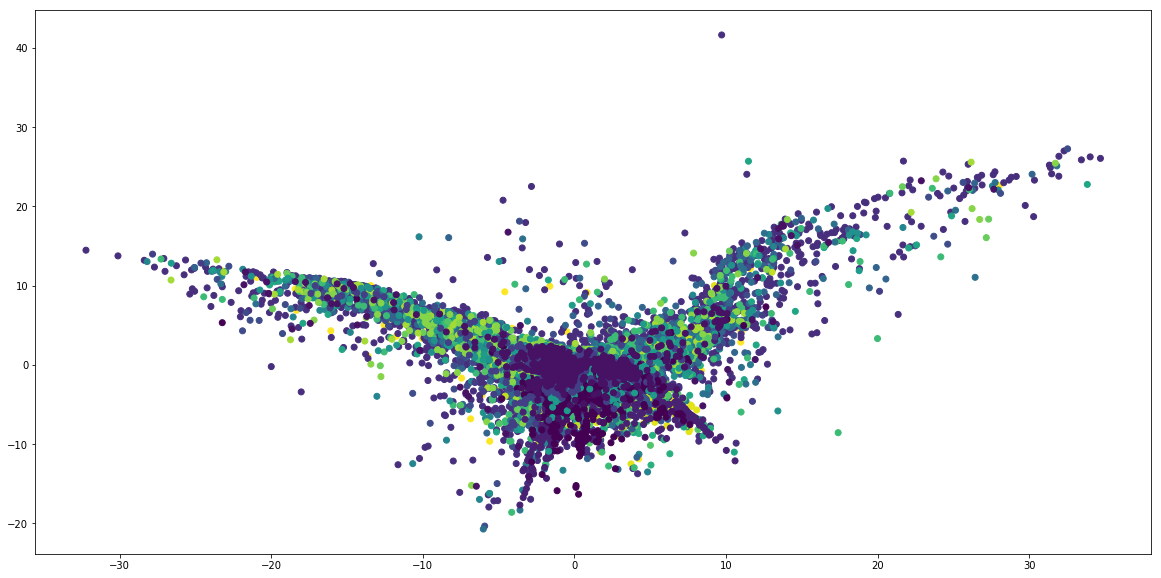

In [28]:
plt.figure(figsize=(20,10)) 

plt.scatter(vector_of_followers_isomap[:, 0], vector_of_followers_isomap[:, 1], c=colors)
plt.show()

Armado de archivos para procesar con embeddings

In [24]:
cx = vector_of_followees.tocoo()
edges = []
checker = list(range(users_train_selected.shape[0]))

for i,j,v in zip(cx.row, cx.col, cx.data):
    #format_str = users_ids[i] + " " + users_ids[j] + " " + str(v)
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [25]:
len(edges)

5121226

In [26]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../edges_follower_weighted.csv", header=False, index=False)

In [27]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    vocabulary=total_users
)

vector_of_followees = vectorizer.fit_transform(users_train_selected["followee_id"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_followees

<29274x507040 sparse matrix of type '<class 'numpy.int64'>'
	with 5121226 stored elements in Compressed Sparse Row format>

In [61]:
cx = vector_of_followees.tocoo()
edges = []
checker = list(range(users_train_selected.shape[0]))

for i,j,v in zip(cx.row, cx.col, cx.data):
    #format_str = users_ids[i] + " " + users_ids[j] + " " + str(v)
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [32]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../edges_follower_weighted.csv", header=False, index=False)

Co-Followers

In [16]:
vector_of_co_followers = vector_of_followees.dot(vector_of_followees.T)
vector_of_co_followers.setdiag(0, k=0)

In [17]:
vector_of_co_followers

<29274x29274 sparse matrix of type '<class 'numpy.longlong'>'
	with 478453894 stored elements in Compressed Sparse Row format>

In [18]:
cx = vector_of_co_followers.tocoo()
edges = []

temp_values = -1
temp_vecinity = -1

passed = True
last_one = -1

for i,j,v in zip(cx.row, cx.col, cx.data):
    if last_one != i:        
        if not passed:
            format_str = str(last_one) + " " + str(temp_vecinity) + " " + str(temp_values)
            edges.append(format_str)
            
        last_one = i
        passed = False    
        temp_values = -1
        temp_vecinity = -1
    
    if v <= 5:
        if v > temp_values:
            temp_values = v
            temp_vecinity = j
        continue
        
    passed = True
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [19]:
len(edges)

101614347

Infomap

In [21]:
!cd ../infomap/infomap-1.1.3 && \
./Infomap --clu -d --silent --weight-threshold 0 ../../edges_followee_weighted.csv ../../

In [22]:
exclude = [i for i, line in enumerate(open('../edges_followee_weighted.clu')) if line.startswith('#')]
communities_infomap = pd.read_csv("../edges_followee_weighted.clu", names=["user_id", "k", "flow"], skiprows = exclude, sep=" ")
del communities_infomap["flow"]

In [23]:
communities_infomap.head()

,user_id,k
0,159460,1
1,193626,1
2,75386,1
3,74261,1
4,441699,1


In [24]:
def get_original_user_id(row):
    return total_users[row["user_id"]]

communities_infomap["real_user_id"] = communities_infomap.apply(get_original_user_id, axis=1)

In [25]:
users_train_final = pd.merge(
    left=communities_infomap,
    right=users_train_selected,
    how='inner',
    left_on="real_user_id",
    right_on="id",
    validate="1:1"
)

In [26]:
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [27]:
users_train_final = users_train_final.loc[:, ["k"]]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(users_train_final, users_complete_location[:,0], test_size=0.30)

In [29]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [30]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'max_depth': 80, 'class_weight': 'balanced', 'min_samples_leaf': 1} 0.0362703152975018


In [31]:
y_predicted = grid_drop.predict(X_test)

In [32]:
accuracy_score(y_test, y_predicted)

0.034360670961750536

In [33]:
balanced_accuracy_score(y_test, y_predicted)

0.05326302861853663

In [34]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


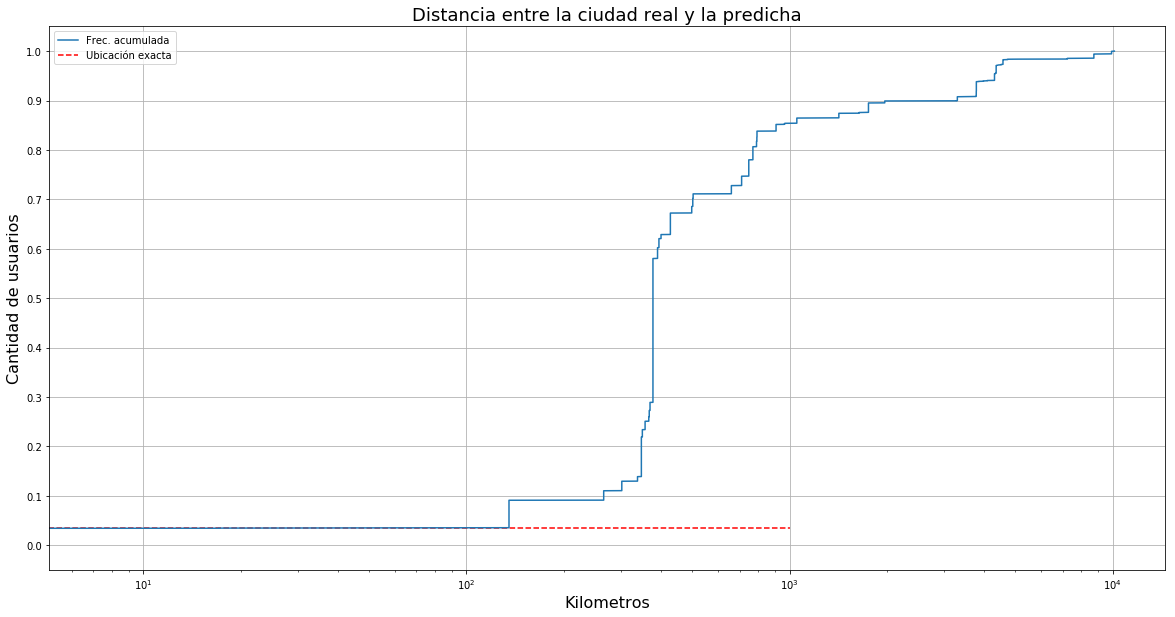

In [35]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

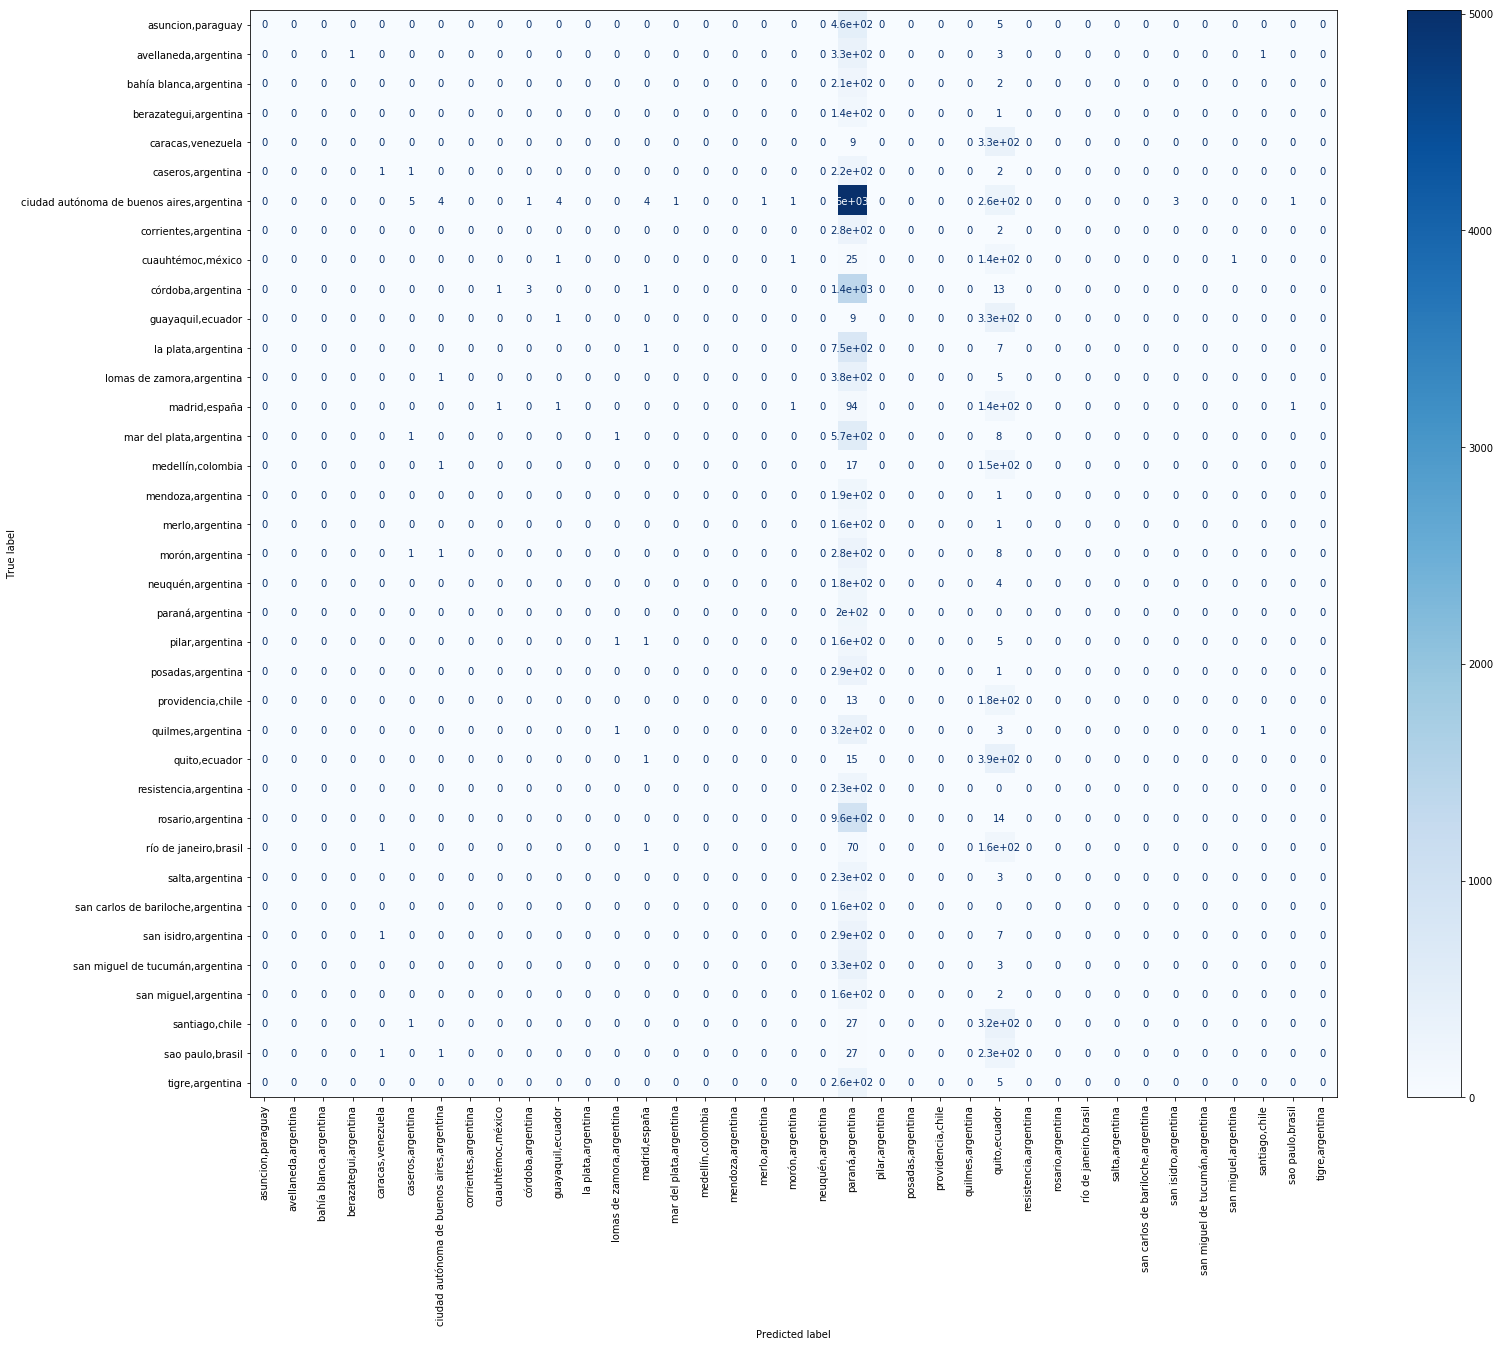

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

Infomap en grafo de followers sin pesos en aristas

In [63]:
!cd ../infomap/infomap-1.1.3 && \
./Infomap --clu -d --silent --weight-threshold 0 ../../edges_follower.csv ../../

In [64]:
exclude = [i for i, line in enumerate(open('../edges_follower.clu')) if line.startswith('#')]
communities_infomap = pd.read_csv("../edges_follower.clu", names=["user_id", "k", "flow"], skiprows = exclude, sep=" ")
del communities_infomap["flow"]

In [65]:
def get_original_user_id(row):
    return total_users[row["user_id"]]

communities_infomap["real_user_id"] = communities_infomap.apply(get_original_user_id, axis=1)

In [66]:
users_train_final = pd.merge(
    left=communities_infomap,
    right=users_train_selected,
    how='inner',
    left_on="real_user_id",
    right_on="id",
    validate="1:1"
)

In [67]:
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [68]:
users_train_final = users_train_final.loc[:, ["k"]]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(users_train_final, users_complete_location[:,0], test_size=0.30)

In [70]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [71]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'max_depth': 80, 'min_samples_leaf': 1, 'class_weight': 'balanced'} 0.44712313624804156


In [72]:
y_predicted = grid_drop.predict(X_test)

In [73]:
accuracy_score(y_test, y_predicted)

0.44984629397700104

In [74]:
balanced_accuracy_score(y_test, y_predicted)

0.49320241173229645

In [75]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


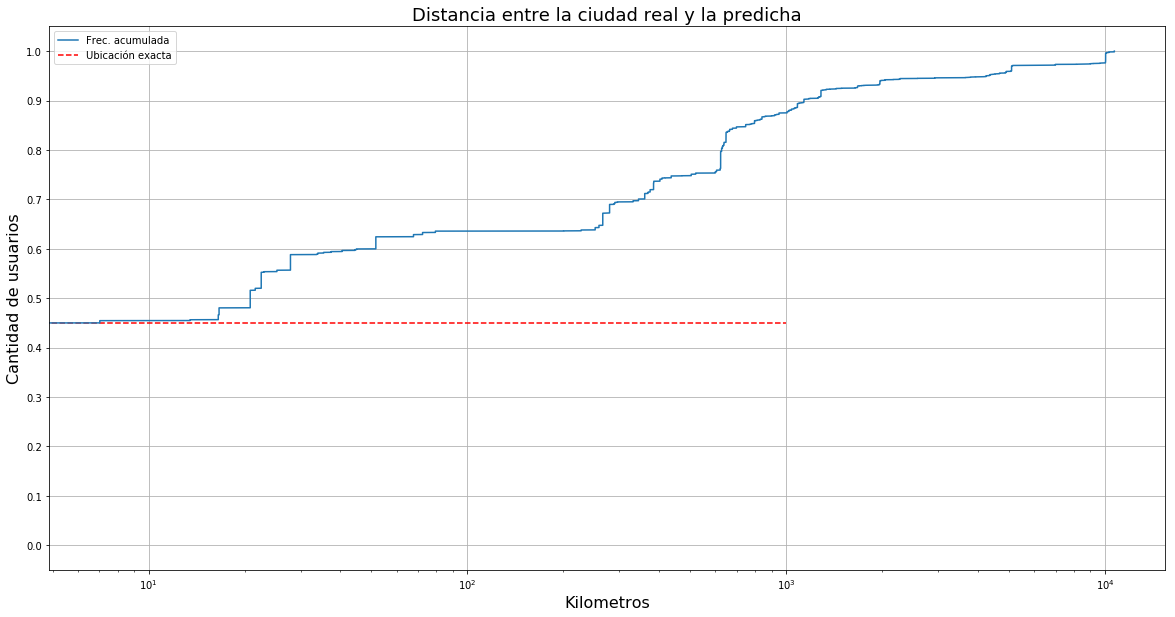

In [76]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

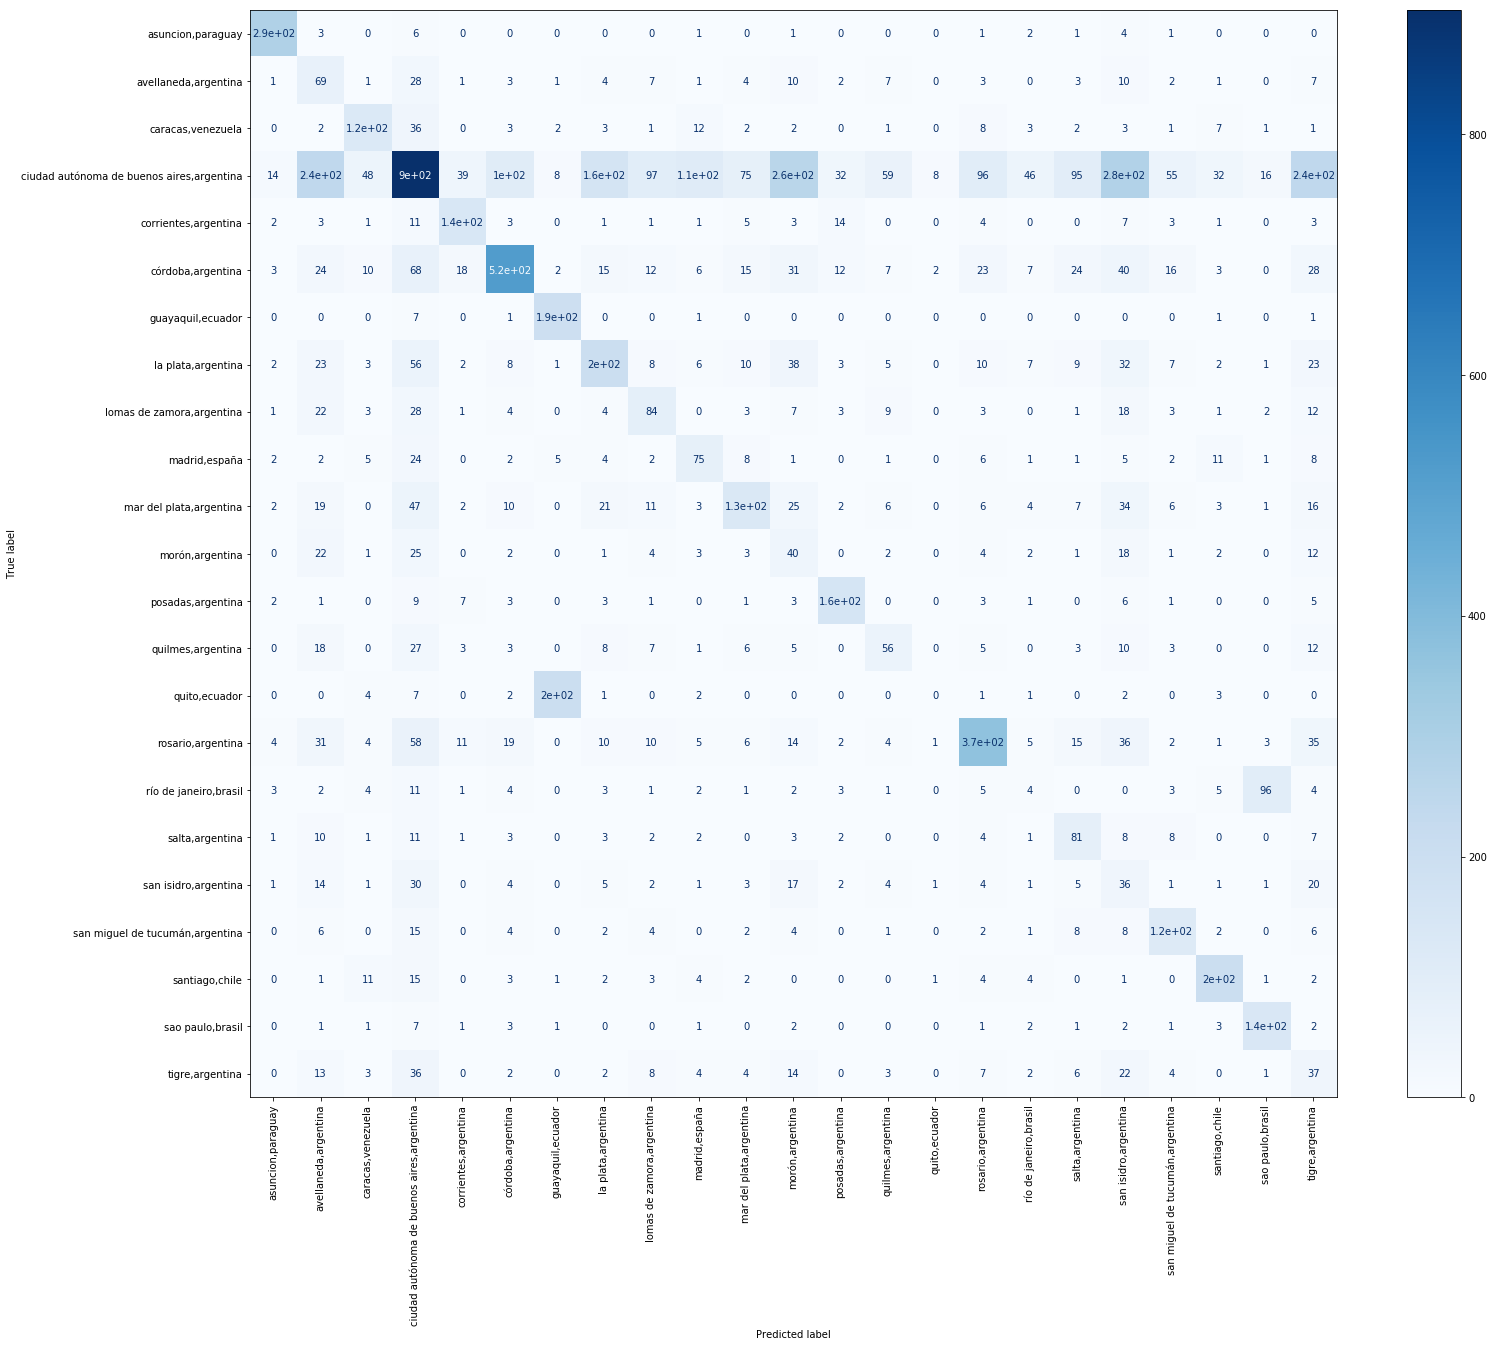

In [77]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

Node2vec

In [115]:
!cd ../snap/examples/node2vec && \
./node2vec -i:../../../edges_follower_weighted.csv -o:../../../edges_follower_weighted_node2vec_2dim.emb -d:2 -p:0.25 -q:1 -l:100 -r:10 -dr -w


An algorithmic framework for representational learning on graphs. [Apr 21 2020]
Input graph path (-i:)=../../../edges_follower_weighted.csv
Output graph path (-o:)=../../../edges_follower_weighted_node2vec_2dim.emb
Number of dimensions. Default is 128 (-d:)=2
Length of walk per source. Default is 80 (-l:)=100
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.25
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=YES
Graph is weighted. (-w)=YES
Output random walks instead of embeddings. (-ow)=NO


In [116]:
columns_node2vec = ["user_id"]

for i in range(0, 2):
    columns_node2vec.append("dim_{}".format(i))

In [117]:
vector_of_followers_node2vec = pd.read_csv("../edges_follower_weighted_node2vec_2dim.emb", names=columns_node2vec, skiprows=1, sep=" ")
vector_of_followers_node2vec.shape

(507040, 3)

In [118]:
def get_original_user_id(row):
    return total_users[int(row["user_id"])]

vector_of_followers_node2vec["real_user_id"] = vector_of_followers_node2vec.apply(get_original_user_id, axis=1)

In [119]:
vector_of_followers_node2vec.head()

,user_id,dim_0,dim_1,real_user_id
0,62527,-0.051887,0.530064,1273939620
1,0,-0.682694,1.109380,772224
2,298464,-0.073467,0.495953,166548469
3,290936,0.116988,0.597722,244134352
4,10654,-0.156998,-0.086524,723579585082826754


In [120]:
users_train_final = pd.merge(
    left=vector_of_followers_node2vec,
    right=users_train_selected,
    how='inner',
    left_on="real_user_id",
    right_on="id",
    validate="1:1"
)

In [121]:
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [122]:
columns_node2vec.remove("user_id")
users_train_final = users_train_final.loc[:, columns_node2vec]

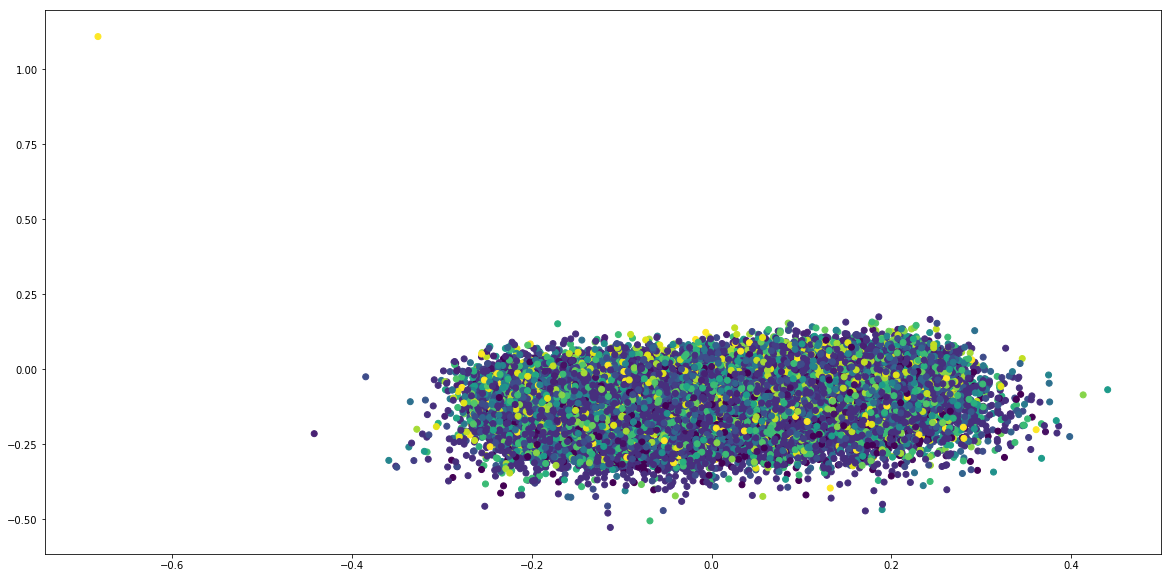

In [124]:
plt.figure(figsize=(20,10)) 

plt.scatter(users_train_final.values[:, 0], users_train_final.values[:, 1], c=colors)
plt.show()

T-SNE

In [123]:
colors = []
for place in users_complete_location[:,0]:
    colors.append(class_names.index(place))

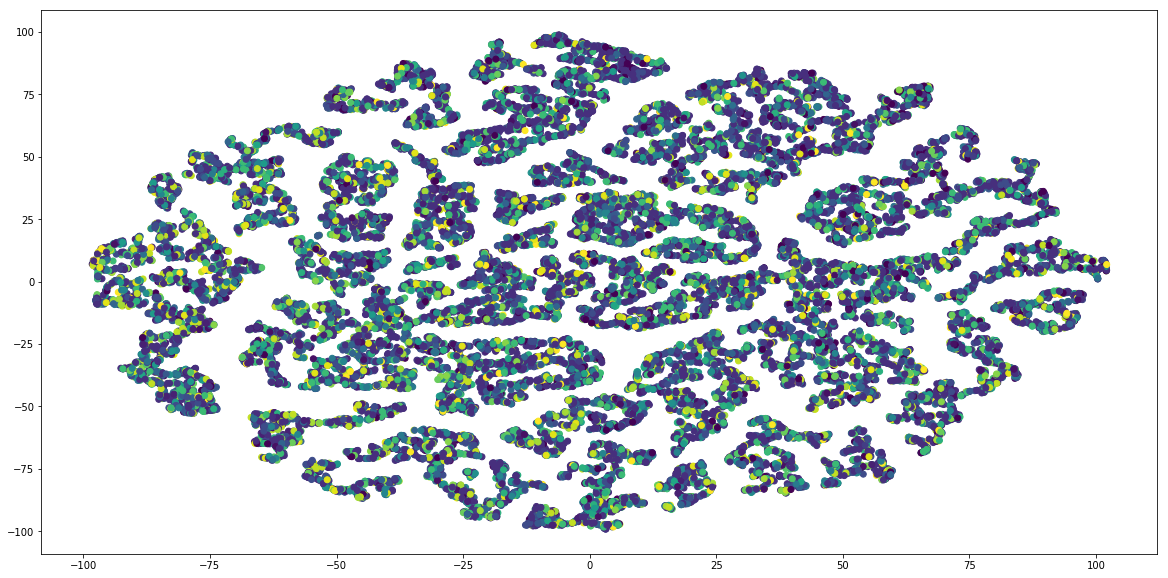

In [126]:
tsne = TSNE(n_components=2, n_jobs=5, perplexity=30, learning_rate=300.0)
X_train_tsne = tsne.fit_transform(users_train_final)

plt.figure(figsize=(20,10)) 

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=colors)
plt.show()

Oslom

In [20]:
import re
def extract_oslom(filename):
    """Funcion que extrae las comunidades detectadas por OSLOM a las que pertence un vertice de la red."""
    clusters = {}
    hashtag_clusters = {}
    data = []
    with open(filename) as f:
        cluster = ""
        for line in f:
            m = re.search("^#module\s([0-9]+).*", line)
            #print line
            if (m is not None):
                cluster = int(m.group(1))
            else:
                l = line.replace('\n', ' ').strip().split(" ")
                l = list(map(int, l))
                clusters[cluster] = l
                for i in l:
                    if not i in hashtag_clusters:
                        hashtag_clusters[i] = set()
                    hashtag_clusters[i].add(cluster)
                    data.append([i, cluster])
    return pd.DataFrame(data=data, columns=["user_id", "cluster"]), hashtag_clusters

In [ ]:
!cd ../oslom/OSLOM2 && \
./oslom_dir -f ../../edges_follower_weighted.csv -w -r 10 -seed 430430 -cp 0.5

setting -f
setting -w
setting -r
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../edges_follower_weighted.csv
Weighted: yes
First Level Runs:			10
Higher Level Runs:			50
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 5121226 factorials...
done
mkdir: cannot create directory ‘../../edges_follower_weighted.csv_oslo_files’: File exists
output files will be written in directory: ../../edges_follower_weighted.csv_oslo_files
network:: 507040 nodes and 5.12123e+06 stubs;	 average degree = 10.1002
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 25335
iteration: 20 number of modules: 6330
collection done 


checked 0 modules 0 were found significant.  Modules to check: 6484. Percentage nodes done: 0
checked 100 modules 94 were found significant.  Modules to check: 6384. Percentage nodes done: 0.644

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 15270
collection done 


possible fusions to check: 14276
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 1
checked 500 unions. Fused: 1
checked 600 unions. Fused: 1
checked 700 unions. Fused: 1
checked 800 unions. Fused: 2
checked 900 unions. Fused: 3
checked 1000 unions. Fused: 3
checked 1100 unions. Fused: 3
checked 1200 unions. Fused: 3
checked 1300 unions. Fused: 3
checked 1400 unions. Fused: 3
checked 1700 unions. Fused: 3
checked 1900 unions. Fused: 3
checked 2000 unions. Fused: 3
checked 2100 unions. Fused: 3
checked 2400 unions. Fused: 3
checked 2500 unions. Fused: 3
checked 2600 unions. Fused: 3
checked 2700 unions. Fused: 3
checked 3100 unions. Fused: 3
checked 3300 unions. Fused: 3

In [30]:
train, clusters = extract_oslom('../edges_follower_weighted.csv_oslo_files/tp')
        
def get_original_user_id(row):
    return total_users[row["user_id"]]

In [31]:
train["real_user_id"] = train.apply(get_original_user_id, axis=1)
        
users_train_final = pd.merge(
    left=train,
    right=users_train_selected,
    how='inner',
    left_on="real_user_id",
    right_on="id",
    validate="m:1"
)

users_train_final = users_train_final.loc[:, ["real_user_id", "cluster", "unified_place", "latitude", "longitude"]]
        
users_train_final = users_train_final.groupby(
    ["real_user_id", "unified_place", "latitude", "longitude"]
)['cluster'].apply(list).reset_index(name='clusters')
        
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [32]:
users_train_final = users_train_final.loc[:, ["clusters"]]
users_train_final["clusters"] = users_train_final["clusters"].apply(lambda l: list(map(str, l)))

In [33]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    token_pattern=r"(?u)\b\w+\b"
)

vector_of_clusters = vectorizer.fit_transform(users_train_final["clusters"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_clusters  

<29274x1246 sparse matrix of type '<class 'numpy.int64'>'
	with 33367 stored elements in Compressed Sparse Row format>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(vector_of_clusters, users_complete_location[:,0], test_size=0.30)

In [35]:
decisiontree = RandomForestClassifier(n_jobs=2)
decisiontree.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [36]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
            'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'min_samples_leaf': 1, 'max_depth': 80, 'class_weight': 'balanced'} 0.4951449787595946


In [37]:
y_predicted = grid_drop.predict(X_test)

In [38]:
accuracy_score(y_test, y_predicted)

0.5239667539565069

In [39]:
balanced_accuracy_score(y_test, y_predicted)

0.4957175006224417

In [40]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


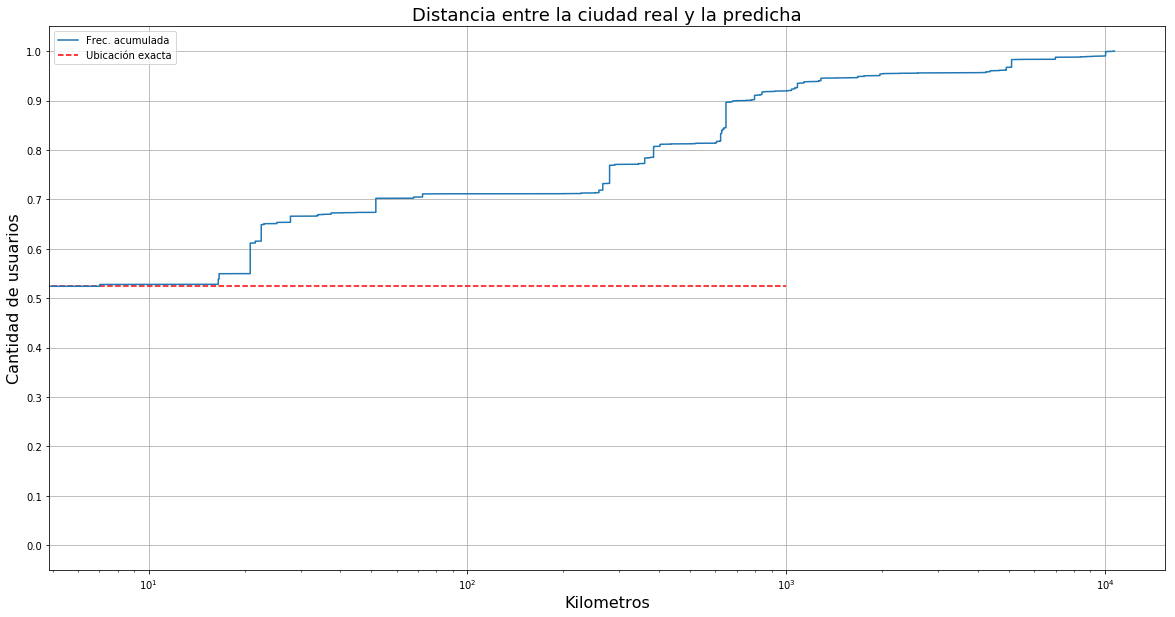

In [41]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

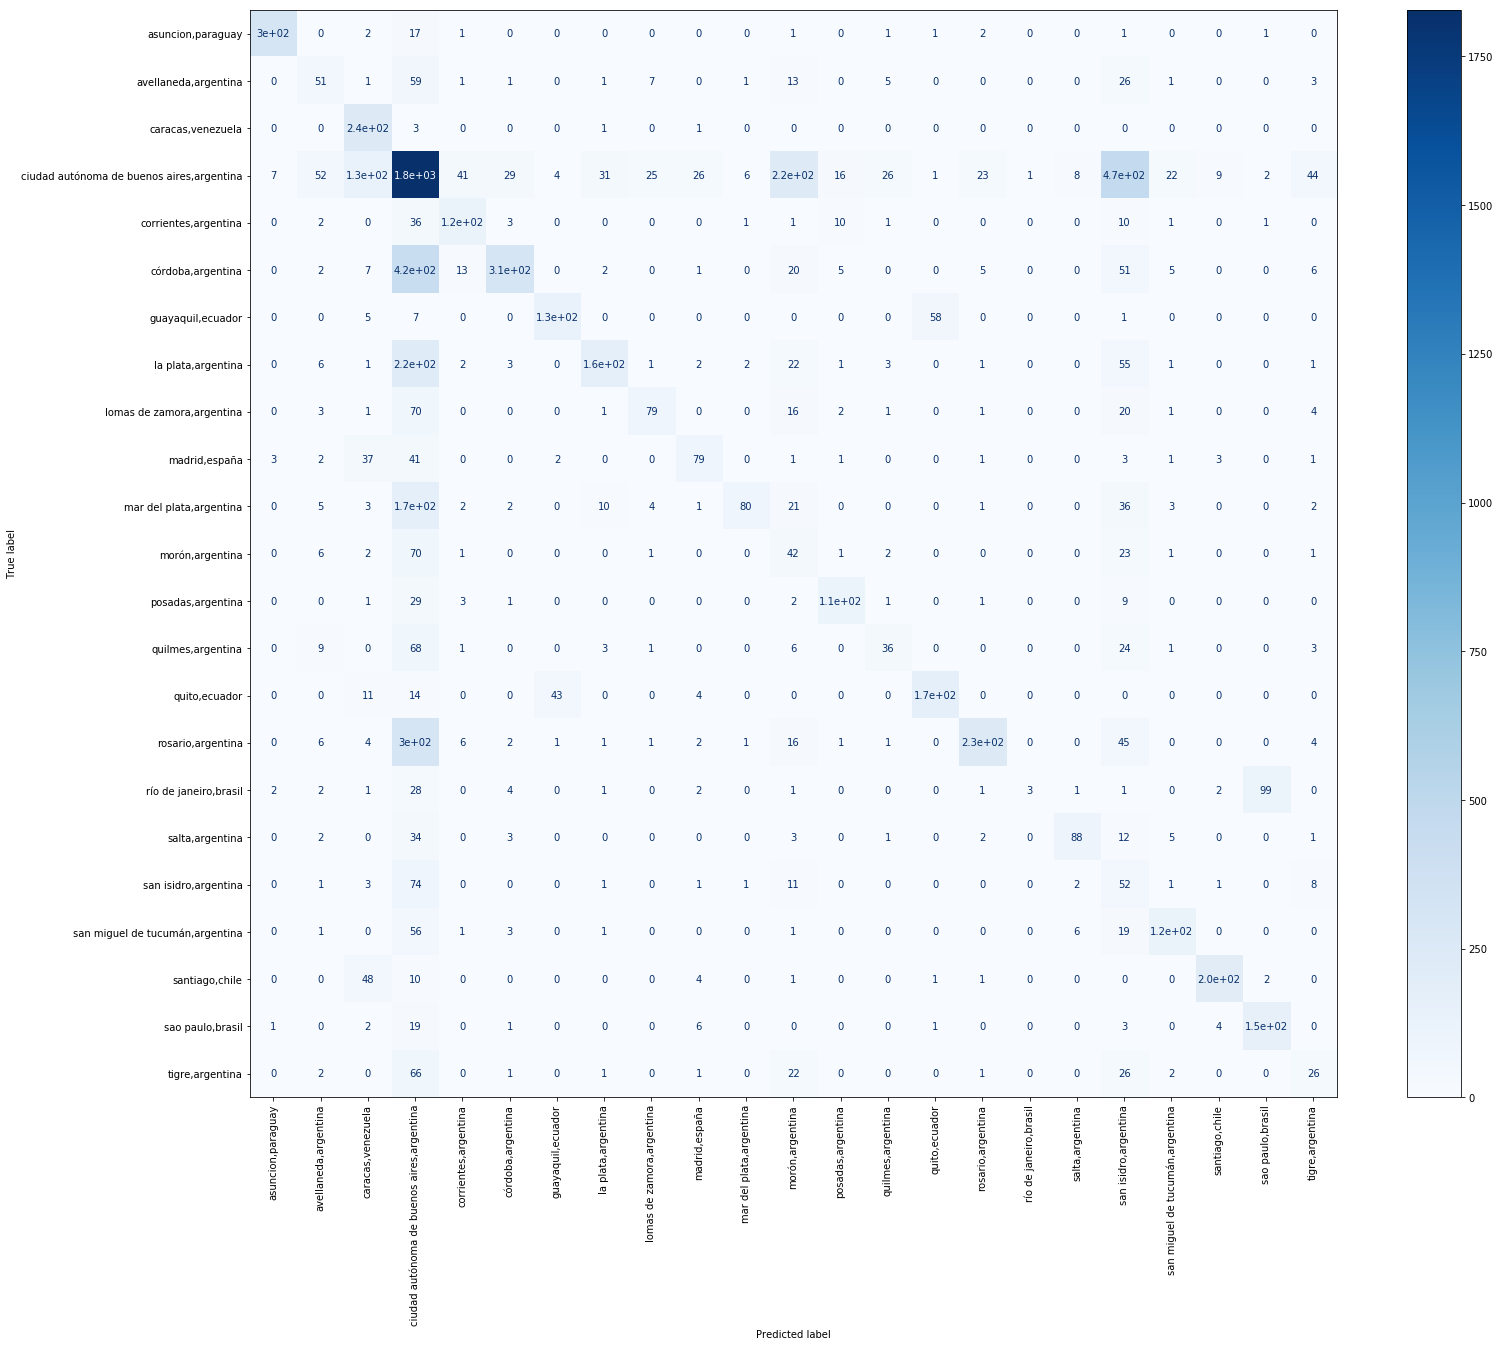

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

Armamos la matriz de coseguidos

In [9]:
users_with_followee = pd.read_pickle("../../../../dosT/ffunes/users_with_followee.pkl")

users_with_followee["follower_id"] = users_with_followee["follower_id"].apply(lambda l: list(map(str, l)))
users_with_followee["id"] = users_with_followee["id"].apply(lambda l: str(l))

users_with_followee["unified_place"] = users_with_followee["place_name"] + ',' + users_with_followee["place_country"]

In [13]:
min_determined_place = users_with_followee.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

In [15]:
min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 750, :]
min_determined_place.shape

(23, 2)

In [16]:
users_train_selected = pd.merge(
    left=users_with_followee,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

users_train_selected.shape

(48999, 7)

In [17]:
users_ids = users_train_selected["id"].apply(lambda l: str(l)).values

a = set()
for x in users_train_selected["follower_id"].values:
    for val in x:
        a.add(str(val))
        
all_users_mentioned = list(a)

total_users = np.concatenate([users_ids, all_users_mentioned])

a = OrderedDict.fromkeys(total_users)

total_users = list(a)

vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    vocabulary=total_users
)

vector_of_followees = vectorizer.fit_transform(users_train_selected["follower_id"].apply(lambda x: ' '.join(x))).astype('int')
vector_of_followees

<48999x451073 sparse matrix of type '<class 'numpy.int64'>'
	with 7392781 stored elements in Compressed Sparse Row format>

In [18]:
vector_of_co_followees = vector_of_followees.dot(vector_of_followees.T)
vector_of_co_followees.setdiag(0, k=0)

In [19]:
vector_of_co_followees

<48999x48999 sparse matrix of type '<class 'numpy.longlong'>'
	with 72420283 stored elements in Compressed Sparse Row format>

In [22]:
cx = vector_of_co_followees.tocoo()
edges = []
checker = list(range(users_train_selected.shape[0]))

for i,j,v in zip(cx.row, cx.col, cx.data):
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

print(len(edges))

df = pd.DataFrame({"edges": edges})
df.to_csv("../results/tmp/edges_co_followees.csv", header=False, index=False)

72420283


In [ ]:
!cd ../oslom/OSLOM2 && \
./oslom_dir -f ../../results/tmp/edges_co_followees.csv -w -fast -seed 430430 -cp 0.5

setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_co_followees.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 72371284 factorials...
done
rm: cannot remove '../../results/tmp/edges_co_followees.csv_oslo_files/*': No such file or directory
output files will be written in directory: ../../results/tmp/edges_co_followees.csv_oslo_files
network:: 48976 nodes and 7.23713e+07 stubs;	 average degree = 1477.69
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 2619
iteration: 20 number of modules: 253
collection done 


checked 0 modules 0 were found significant.  Modules to check: 253. Percentage nodes done: 0
